# Coverage Evaluation of Physical Broadcast Channels (PBCH) in 5G Networks
The control channels are used to communicate the downlink control information (DCI) in 5G Networks. This control information is crucial for decoding the actual data blocks which is carried using the physical downlink shared channel (PDSCH). In this tutorial we will demonstrate the link-level and system-level performance of control channel for different aggregation levels. The aggregation level allows the base-station to control the amount of resources allocated to PDCCH for transitting the DCI.

## Import Libraries
### Import Python Libraries

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

### Import 5G Toolkit Libraiers

In [2]:
import sys
sys.path.append("../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.ChannelModels     import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator

from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator

from toolkit5G.ChannelProcessing  import ApplyChannel, AddNoise
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.ReceiverAlgorithms import ChannelEstimationAndEqualizationPBCH

from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Simulation Parameters

In [3]:
terrain          = "CDL-A"    # Terrain      # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 3.6*10**9        # Carrier frequency 3.6 GHz
scs              = 30*10**3   # Subcarrier Spacing
nBatches         = 100       # Number of Batches considered for simulation
numRBs           = 40         # Please don't change this. The simulation will break down
Bandwidth        = 10*10**6   # System bandwidth
Nfft             = 512        # FFT-size
bandwidthTx      = 10*(10**6);           # Transmission bandwidth
nSymbolFrame     = 140*int(scs/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

nBSs             = 3          # number of BSs 
nUEs             = nBatches   # number of UEs

txAntStruture    = np.array([1,1,4,4,2]) # Tx Antenna Structure
rxAntStruture    = np.array([1,1,2,2,1]) # Rx Antenna Structure
Nt               = txAntStruture.prod()
Nr               = rxAntStruture.prod()

print()
print("                  Terrain: "+terrain)
print("        Carrier Frequency: "+str(carrierFrequency/10**9)+" GHz")
print("       Subcarrier-Spacing: "+str(scs)+" kHz")
print("                Bandwidth: "+str(Bandwidth/10**6)+" MHz")
print("                 FFT-size: "+str(Nfft))
print("Number of Resource Blocks: "+str(nBatches))
print("Number of User Equipments: "+str(nUEs))
print("  Number of Base Stations: "+str(nBSs))
print("  Number of Base Antennas: "+str(Nt))
print("    Number of UE Antennas: "+str(Nr))

print()



                  Terrain: CDL-A
        Carrier Frequency: 3.6 GHz
       Subcarrier-Spacing: 30000 kHz
                Bandwidth: 10.0 MHz
                 FFT-size: 512
Number of Resource Blocks: 100
Number of User Equipments: 100
  Number of Base Stations: 3
  Number of Base Antennas: 32
    Number of UE Antennas: 4



## Generate the Wireless Channel : CDL-A

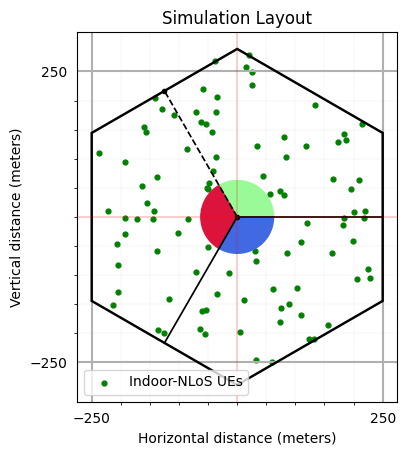

             Number of BSs: 3
          Shape of Channel: (1, 1, 3, 100, 512, 4, 32)
*****************************************************



In [4]:

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = rxAntStruture)
ueAntArray()

# # Radiation Pattern of Rx antenna element 
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna 
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = txAntStruture)
bsAntArray()
    
# # Radiation Pattern of Tx antenna element 
# bsAntArray[0].displayAntennaRadiationPattern()

# # Node Mobility
# timeInterval = 15/scs           # number of SnapShots
# timeInst   = np.linspace(0, timeInterval, 14)
# UEroute    = NodeMobility("randomWalk", numUEs, timeInst, 1, 1, -0.7853981633974483, 0.7853981633974483, False)
# UEroute()

# fig, ax    = UEroute.displayRoute()
# ax.set_aspect(True)

# Layout Parameters
isd                  = 500        # inter site distance
minDist              = 3          # min distance between each UE and BS 
ueHt                 = 1.5         # UE height
bsHt                 = 10          # BS height
bslayoutType         = "Hexagonal" # BS layout type
ueDropType           = "Hexagonal" # UE drop type
htDist               = "equal"     # UE height distribution
ueDist               = "equal"     # UE Distribution per site
nSectorsPerSite      = 3           # number of sectors per site
maxNumFloors         = 1           # Max number of floors in an indoor object
minNumFloors         = 1           # Min number of floors in an indoor object
heightOfRoom         = 3           # height of room or ceiling in meters
indoorUEfract        = 0#0.5         # Fraction of UEs located indoor
lengthOfIndoorObject = 3           # length of indoor object typically having rectangular geometry 
widthOfIndoorObject  = 3           # width of indoor object
#forceLOS             = True       # boolen flag if true forces every link to be in LOS state
forceLOS             = False      # boolen flag if true forces every link to be in LOS state

# simulation layout object                                 
simLayoutObj = SimulationLayout(numOfBS = nBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt, 
                                ISD = isd,
                                layoutType = bslayoutType,
                                ueDropMethod = ueDropType, 
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None, 
                                force3GPPSpatialConsistencyParameters = True, 
                                enableSpatialConsistencyLoS = True)

simLayoutObj(terrain = terrain, 
             carrierFreq = carrierFrequency, 
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS)

simLayoutObj.linkState = simLayoutObj.linkState*False

# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()

# paramGen = simLayoutObj.getParameterGenerator(delaySpread=100*(10**(-9)),
#                                               enableAbsoluteDelays=True,
#                                               enableSpatialConsistencyForLSPs = True, 
#                                               enableSpatialConsistencyForSSPs = True,
#                                               enableSpatialConsistencyForInitialPhases = True)
paramGen = simLayoutObj.getParameterGenerator(delaySpread=100*(10**(-9)))
#paramGen.displayClusters((0,0,0), rayIndex = 5)

channel = paramGen.getChannel()
Hf      = channel.ofdm(scs, Nfft, normalizeChannel = True)

Nt        = bsAntArray.numAntennas # Number of BS Antennas
Nr        = ueAntArray.numAntennas

print("             Number of BSs: "+str(nBSs))
print("          Shape of Channel: "+str(Hf.shape))
print("*****************************************************")
print()

## Set SSB and Time-Frequency OFDM Configurations/Parameters

In [5]:
## This class fetches valid set of 5G parameters for the system configurations 
tfParams         = TimeFrequency5GParameters(Bandwidth, scs, fftsize=Nfft)
tfParams(nSymbolFrame, typeCP = "normal")
nRB              = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff             = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft             = 512                 # FFT-size for OFDM
lengthCP         = tfParams.lengthCP    # CP length


lamda                           = 3e8/carrierFrequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(carrierFrequency, nSCSOffset, ssbType="caseA",
                                                             nssbCandidatesInHrf = 8, isPairedBand = False, 
                                                             withSharedSpectrumChannelAccess = False)

systemFrameNumber               = ssbParameters.systemFrameNumber 
subCarrierSpacingCommon         = ssbParameters.subCarrierSpacingCommon 
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset 
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition 
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset 
choiceBit                       = ssbParameters.choiceBit 
ssbType                         = ssbParameters.ssbType 
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit 
cellBarred                      = ssbParameters.cellBarred 
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection 
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

nFrames                         = 0.5
Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________

## Generate the Synchronization Signal Block (SSB) Grid

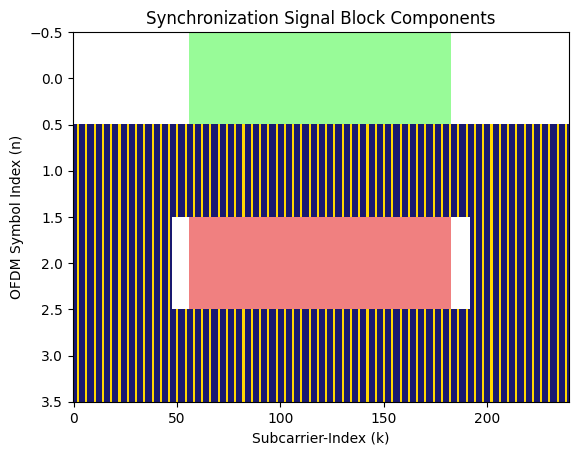

In [6]:
N_ID2        = np.arange(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = 0
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

ssbIndex     = np.arange(nssbCandidatesInHrf)

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID.repeat(8), np.tile(np.arange(nssbCandidatesInHrf), 3), nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen).reshape(3,8,-1)


# Generate PBCH symbols
pbchSymbols = np.zeros((3, 8, 432), dtype=np.complex64)
ssb         = np.zeros((3, 8, 4, 240), dtype=np.complex64)
for i in range(3):
    pbchObject   = PBCH(carrierFrequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                        controlResourceSet0, searchSpace0, cellBarred, 
                        intraFrequencyReselection, systemFrameNumber, ssbSubCarrierOffset, 
                        hrfBit, ssbIndex, N_ID[i], nssbCandidatesInHrf)

    pbchSymbols[i] = pbchObject()
    
    ssbObject      = SSB_Grid(N_ID[i])
    ssb[i]         = ssbObject(pssSequence[i], sssSequence[i], 
                               dmrsSequence[i], pbchSymbols[i])
    
fig, ax = ssbObject.displayGrid()

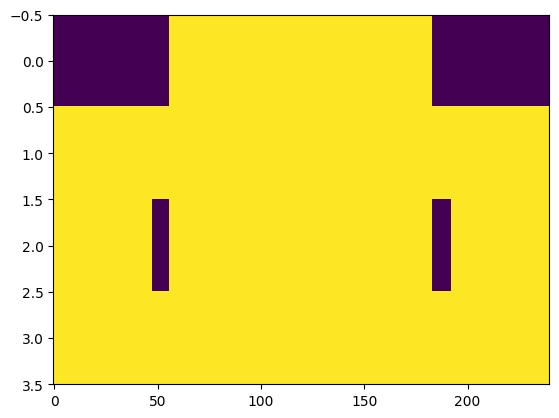

In [7]:
si = np.random.randint(3)
bi = np.random.randint(8)

fig, ax = plt.subplots()
ax.imshow(np.abs(ssb[si,bi]), interpolation= "nearest", aspect='auto')
plt.show()

## Generate the Transmission Grid

In [8]:
numSymbols = 56
Pt         = 1
XGrid      = np.zeros((nBSs, Nt, numSymbols, numRBs*12), dtype = np.complex64)
Xf         = np.zeros((nBSs, Nt, numSymbols, Nfft),      dtype = np.complex64)


## Loading SSB to SSB Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.ones(nssbCandidatesInHrf, dtype=int)

# ssbRGobject = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = carrierFrequency, N_RB=nRB,
#                               kssb=int(ssbSubCarrierOffset), offsetToPointA = int(nRB*0.5-10),
#                               scsCarrier = subCarrierSpacingCommon,
#                               ssbPositionInBurst = ssbPositionInBurst, ssbPeriodicity = None, nHF=None,
#                               nFrames = 0.1*nFrames, isPairedBand = isPairedBand, 
#                               withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)


ssbRGobject  = ResourceMapperSSB(ssbType, carrierFrequency, isPairedBand, withSharedSpectrumChannelAccess)

antLocations = bsAntArray.locations[0,0].reshape(-1,3)
azimuth      = np.arange(0, nssbCandidatesInHrf)*(2*np.pi/3)/nssbCandidatesInHrf
secAngle     = np.arange(nSectorsPerSite)*(2*np.pi/3)
theta        = 95*np.pi/180

for nbs in range(nBSs):
    
    ssbGrid = ssbRGobject(ssb[nbs], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset[0],
                          offsetInRBs = 0, numRBs = numRBs)
    
    for nbm in range(nssbCandidatesInHrf):
        
        phi = azimuth[nbm] + secAngle[nbs%nSectorsPerSite]
        steeringVector = np.stack((np.sin(theta, dtype = np.float32)*np.cos(phi, dtype = np.float32),
                                   np.sin(theta, dtype = np.float32)*np.sin(phi, dtype = np.float32),
                                   np.cos(theta, dtype = np.float32)), axis = -1)[...,np.newaxis]

        beamVectors    = (antLocations@steeringVector)/lamda
        beamVectors    = np.sqrt(Pt/Nt)*np.exp(-1j*2*np.pi*beamVectors)
        
        
        n = ssbRGobject.symbolIndices[nbm]
        XGrid[nbs,:,n:n+4] = beamVectors[...,np.newaxis]*ssbGrid[np.newaxis,n:n+4]
        
bwpOffset = np.random.randint(Nfft - numRBs*12)
Xf[...,bwpOffset:bwpOffset+numRBs*12] = XGrid

## Pass through the Wireless Channel

In [10]:
Yf = (Hf[0,0,:,:,np.newaxis]@Xf.transpose(0,2,3,1)[:,np.newaxis,...,np.newaxis])[...,0]

## Display the Heatmap for the Received Grid

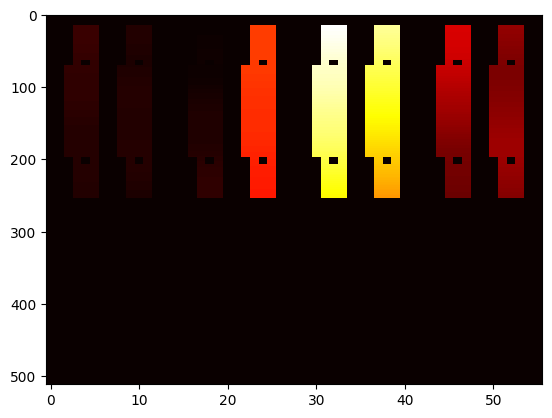

In [11]:
ui = np.random.randint(nUEs)
bi = np.random.randint(nBSs)
ai = np.random.randint(Nr)

fig, ax = plt.subplots()
ax.imshow(np.abs(Yf[bi,ui,:,:,ai]).T, cmap = "hot", interpolation= "nearest", aspect='auto')
plt.show()

## Link level Simulation: BLER for each SNR value

In [12]:
# Rx Beamforming
numRxBeams = 8
combiner   = np.fft.fft(np.eye(numRxBeams))[:,0:Nr]

numPoints   = 10
SNRdB       = np.linspace(-20, -10, numPoints, endpoint=True)
# SNRdB      = np.linspace(-13.5, -7.5, numPoints, endpoint=True)
SNR         = 10**(SNRdB/10)
ssbEsti     = np.zeros((nBSs, nUEs, nssbCandidatesInHrf, 4, 240, numRxBeams), dtype = np.complex64)
ssbEst      = np.zeros((nUEs, 4, 240), dtype = np.complex64)
cellID      = np.zeros(nUEs, dtype = np.int32)
beamIndices = np.zeros(nUEs, dtype = np.int32)
rxbeamIdxs  = np.zeros(nUEs, dtype = np.int32)
rsrp        = np.zeros(nUEs)

polarDecoder   = "SCL"
symbolDemapper = "maxlog"
extractMIBinfo = False
crcChecks  = np.zeros((nUEs), dtype = np.bool_)
bler       = np.zeros(SNR.size)

for i in range(SNR.size):
    
    print("********** [i = "+str(i)+" | SNR(dB) = "+str(SNRdB[i])+"] **********")
    
    ## Add noise to the received grid
#     Y  = AddNoise(False)(Yf, 1/SNR[i], 0)
#     Yr = Y[...,bwpOffset:bwpOffset+numRBs*12,:].sum(-1)
    
    
    Yr  = AddNoise(False)(Yf, 1/SNR[i], 0)[...,bwpOffset:bwpOffset+numRBs*12,:]
        
    
    for nbm in range(nssbCandidatesInHrf):
        n = ssbRGobject.symbolIndices[nbm]
        ssbEsti[:,:,nbm] = (combiner.reshape(1,1,1,1,1,numRxBeams,Nr)@Yr[:,:,n:n+4,ssbSubCarrierOffset[0]:ssbSubCarrierOffset[0]+240,:, np.newaxis])[...,0]
    
    
    for nue in range(nUEs):
        power       = np.abs(ssbEsti[:,nue]).sum(-3).sum(-2)
        rsrp[nue]   = power.max()
        idX         = np.argwhere(power == rsrp[nue])
        cellID[nue]      = idX[0][0]
        beamIndices[nue] = idX[0][1]
        rxbeamIdxs[nue]  = idX[0][2]
        ssbEst[nue] = ssbEsti[cellID[nue], nue, beamIndices[nue],:,:,rxbeamIdxs[nue]]
    
    ## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
    ## Object for Channel Estimation
    
    idx = cellID == 0
    if(idx.sum()>0):
        chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile = False)
        pbchEstimate   = chanEst(ssbEst[idx], dmrsSequence[0,beamIndices[idx]], 0)
        ## PBCH Chain for Decoding information
        # carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
        pbchDecoder    = PBCHDecoder(carrierFrequency, 0, nssbCandidatesInHrf, beamIndices[idx], polarDecoder, symbolDemapper)
        rxMIB, check   = pbchDecoder(pbchEstimate, SNR[i], extractMIBinfo)
        crcChecks[idx] = check.flatten()

    idx = cellID == 1
    if(idx.sum()>0):
        chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile = False)
        pbchEstimate   = chanEst(ssbEst[idx], dmrsSequence[1,beamIndices[idx]], 1)
        ## PBCH Chain for Decoding information
        # carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
        pbchDecoder    = PBCHDecoder(carrierFrequency, 1, nssbCandidatesInHrf, beamIndices[idx], polarDecoder, symbolDemapper)
        rxMIB, check   = pbchDecoder(pbchEstimate, SNR[i], extractMIBinfo)
        crcChecks[idx] = check.flatten()

    idx = cellID == 2
    if(idx.sum()>0):
        chanEst        = ChannelEstimationAndEqualizationPBCH(estimatorType = "ZF", interpolatorType = "Linear", isUEmobile = False)
        pbchEstimate   = chanEst(ssbEst[idx], dmrsSequence[2,beamIndices[idx]], 2)    
        ## PBCH Chain for Decoding information
        # carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
        pbchDecoder    = PBCHDecoder(carrierFrequency, 2, nssbCandidatesInHrf, beamIndices[idx], polarDecoder, symbolDemapper)
        rxMIB, check   = pbchDecoder(pbchEstimate, SNR[i], extractMIBinfo)
        crcChecks[idx] = check.flatten()
    
    bler[i] = 1 - np.mean(crcChecks)
    print("********** [SNR(dB) = "+str(SNRdB[i])+" | BLER = "+str(bler[i])+" ] **********")
    
# np.savez("Database/SNR_vs_BLER-1.npz", SNRdB=SNRdB, bler = bler)

********** [i = 0 | SNR(dB) = -20.0] **********


/home/tenet/Startup/Packages/5G_Toolkit/version15/Projects/10.Link_Level_and_System_Level_Simulation_for_Physical_Broadcast_Channels/../../toolkit5G/ChannelCoder/PolarCoder/polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


********** [SNR(dB) = -20.0 | BLER = 0.19999999999999996 ] **********
********** [i = 1 | SNR(dB) = -18.88888888888889] **********
********** [SNR(dB) = -18.88888888888889 | BLER = 0.07999999999999996 ] **********
********** [i = 2 | SNR(dB) = -17.77777777777778] **********
********** [SNR(dB) = -17.77777777777778 | BLER = 0.040000000000000036 ] **********
********** [i = 3 | SNR(dB) = -16.666666666666668] **********
********** [SNR(dB) = -16.666666666666668 | BLER = 0.010000000000000009 ] **********
********** [i = 4 | SNR(dB) = -15.555555555555555] **********
********** [SNR(dB) = -15.555555555555555 | BLER = 0.0 ] **********
********** [i = 5 | SNR(dB) = -14.444444444444445] **********
********** [SNR(dB) = -14.444444444444445 | BLER = 0.0 ] **********
********** [i = 6 | SNR(dB) = -13.333333333333332] **********
********** [SNR(dB) = -13.333333333333332 | BLER = 0.0 ] **********
********** [i = 7 | SNR(dB) = -12.222222222222221] **********
********** [SNR(dB) = -12.222222222222221 

## Block Error Rate Performance

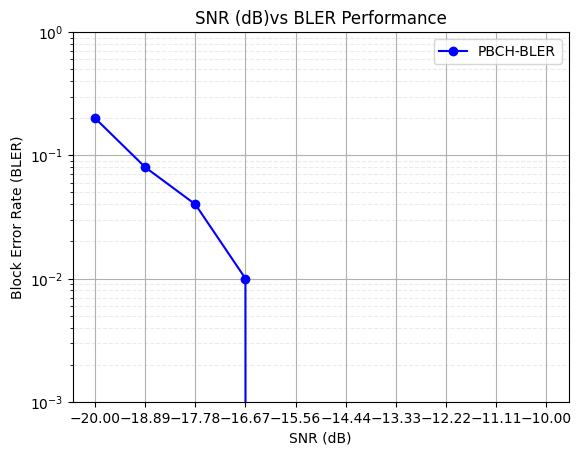

In [14]:
fig, ax = plt.subplots()

ax.semilogy(SNRdB, bler, "-b", marker = "o", label = "PBCH-BLER")
plt.legend(loc="best")

ax.set_xticks(SNRdB)
ytck = (0.1**(np.arange(1, 4))).repeat(9)*np.tile(np.arange(10, 1,-1), [3])
ytck = np.concatenate([[1],ytck])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(0.1**(np.arange(0, 4)), minor=False)

ax.set_title('SNR (dB)vs BLER Performance')
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Block Error Rate (BLER)')

ax.grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax.grid(which = 'major', alpha = 1)
plt.show()

## Block Error Rate: Averaged over a 10000 batches

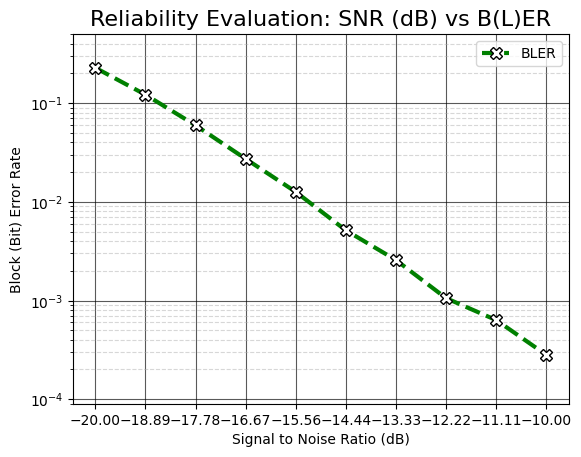

In [15]:
# Load-dataset
filename = "Database/PBCH-Nt-"+str(Nt)+"_Nr-"+str(Nr)+".npz"
dB       = np.load(filename)

fig, ax = plt.subplots()

ax.semilogy(dB["SNRdB"], dB["bler"], "--g", marker = "X", lw = 3, mec = "k", mfc = "w", ms = 9, label="BLER")
ax.legend(loc="best")
ax.set_xlabel("Signal to Noise Ratio (dB)")
ax.set_ylabel("Block (Bit) Error Rate")
ax.set_title("Reliability Evaluation: SNR (dB) vs B(L)ER", fontsize = 16)

ax.set_xticks(SNRdB)
ytck = (0.1**(np.arange(1, 10))).repeat(9)*np.tile(np.arange(10, 1,-1), [9])
ytck = np.concatenate([[1],ytck])
ax.set_yticks(ytck, minor=True)
ax.set_yticks(0.1**(np.arange(0, 9)), minor=False)
ax.set_ylim([0.9*10**-4,0.5])

ax.grid(which = 'minor', alpha = 0.5, linestyle = '--')
ax.grid(which = 'major', alpha = 0.65, color = "k")

plt.show()